# Postprocess SWAT Simulations (4) - Water Yield Changes on Map

In this notebook, we'll process the SWAT subbasin output file, which contains summary information for each of the subbasins in the watershed. The reported values for the different variables are the total amount or weighted average of all HRUs within the subbasin. See more from [SWAT2012 Input/Output File Documentation](https://swat.tamu.edu/documentation/2012-io/). The data are also managed in SQLite databases by the tool of [SWAT Output Viewer](https://swatviewer.com/). 

We'll link a spatial map with a Pandas dataframe and then to produce a spatial **category map** of water yield changes in each season via [PySAL](http://pysal.readthedocs.io/en/latest/). This is equivalent to adding extra properties to a static map from other data sources such as CSV, EXCEL, SQLite database, etc., as long as they have a common column or property.

[PySAL](http://pysal.readthedocs.io/en/latest/)is an open source library of spatial analysis functions written in Python intended to support the development of high level applications. The tutorial presented here only illustrated a little of the functionality in PySAL. Further details on PySAL functionality can be found in the [API](http://pysal.readthedocs.io/en/latest/library/index.html).

*It is worth noting that all data in this series are fake data and only are used to show how to postprocess SWAT simulations through open source tools.*

## 1. Load all needed libraries

In [1]:
import geopandas as gpd 
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import pysal

%matplotlib inline

## 2. Read Watershed map

Here the operations are similar to the [tutorial 3](https://www.linkedin.com/pulse/postprocess-swat-simulations-3-view-watershed-geopandas-yin/). *Read shapefile, transform projection, and add a column of coordinate*.

In [2]:
geo_df = gpd.read_file("data\Watersheds\subs1.shp")
geo_df.set_index(geo_df["Subbasin"].astype(int), inplace=True)
geo_df_ll = geo_df.to_crs(epsg=4269)

geo_df_ll['coords'] = geo_df_ll['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_df_ll['coords'] = [coords[0] for coords in geo_df_ll['coords']]

## 3. Calculate Seasonal changes in each subbasin
The calculation and statistical analysis are similar to the [tutorial 2](https://www.linkedin.com/pulse/postprocess-swat-simulations-2-runoff-change-chonghua-yin/). For example, query table names, columns in a table.

To simplify reading, we put the code into a function. However, this time we only used the SUB table and the variable of water yield (WYLD, mm H2O). The net amount of water that leaves the subbasin and contributes to streamflow in the reach during the time step.

In [3]:
def read_sub(db_name):
    con = sqlite3.connect(db_name)
    cursor = con.cursor()

    df = pd.read_sql_query("SELECT SUB, YR, MO, WYLDmm from sub", con)
    df = df.set_index(['MO'])
    con.close()
    return df

In addition, we only care about seasonal changes. Therefore, have to convert monthly data into seasonal means.

In [4]:
def calculate_ssnmean(df):
    quarters = {1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 6: 'JJA',
            7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON', 12: 'DJF'}
    
    ssndf = df.groupby(['SUB',quarters])['WYLDmm'].mean()
    ssndf = ssndf.reset_index()
    ssndf.set_index(['SUB'])
    ssndf = ssndf.rename(index=str, columns={"level_1":"SSN"})
    pivoted = ssndf.pivot(index='SUB', columns='SSN', values='WYLDmm')
    return pivoted

### 3.1 Read baseline water yields

In [5]:
db_name = 'data\\baseline\\result_664_monthly.db3'
df_bsl = read_sub(db_name)
df_bsl.head()

,SUB,YR,WYLDmm
MO,,,
1,1,1981,0.298896
1,2,1981,32.593430
1,3,1981,5.274457
1,4,1981,20.693169
1,5,1981,34.826622


### 3.2 Read water yield in future

In [6]:
db_name = 'data\\future\\result_664_monthly.db3'
df_fut = read_sub(db_name)
df_fut.head()

,SUB,YR,WYLDmm
MO,,,
1,1,1981,0.246584
1,2,1981,29.811039
1,3,1981,3.889500
1,4,1981,18.781422
1,5,1981,35.266075


### 3.3 Calculate seasonal mean

In [7]:
pivoted_bsl = calculate_ssnmean(df_bsl)
pivoted_fut = calculate_ssnmean(df_fut)
print(pivoted_fut.head())
print(pivoted_bsl.head())

SSN        DJF         JJA         MAM        SON
SUB                                              
1     7.048934    4.785740   29.062999   0.678388
2    15.207945  255.281550   94.705401  83.778716
3    21.803301   64.937924  165.375254  10.711489
4     9.352786  237.984487  150.292811  53.672928
5    59.665812   22.795662   84.863194   6.984006
SSN        DJF         JJA         MAM        SON
SUB                                              
1     5.259590    6.429593   31.715768   0.680024
2    18.733498  259.313891   68.536122  98.704437
3    13.215879   72.841203  166.007980  11.937546
4    11.710252  255.563129  116.047286  63.738850
5    59.482203   23.867457   86.821729   6.887843


### 3.4 Calculate seasonal changes

In [8]:
pivoted_ch = (pivoted_fut - pivoted_bsl)/pivoted_bsl*100.0
pivoted_ch = pivoted_ch.reindex()
pivoted_ch.head()

SSN,DJF,JJA,MAM,SON
SUB,,,,
1,34.020604,-25.566977,-8.364198,-0.240460
2,-18.819515,-1.555004,38.183191,-15.121631
3,64.978062,-10.850012,-0.381142,-10.270593
4,-20.131646,-6.878395,29.509974,-15.792445
5,0.308679,-4.490616,-2.255812,1.396118


## 4. Spatial join

Merge the geo-dataframe with the seasonal change dataframe. To merge two tables, have to rename the column of Subbasin to SUB in geo_df_ll

In [9]:
geo_df_ll.rename(columns = {"Subbasin" : "SUB"}, inplace = True)
geo_df_ll.head()

,OBJECTID,GRIDCODE,SUB,Area,Slo1,Len1,Sll,Csl,Wid1,Dep1,...,Elev,ElevMin,ElevMax,Bname,Shape_Leng,Shape_Area,HydroID,OutletID,geometry,coords
Subbasin,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,675995.835055,23.175461,180463.680407,15.239256,1.706715,256.186430,4.425078,...,2886.131934,1176.0,5184.0,,628216.7982,6.759958e+09,300001,100001,"POLYGON ((71.4325946919343 39.03757777443316, ...","(70.5453857151, 39.2361201273)"
2,2,2,2,790745.086365,14.554012,231915.147016,24.382810,0.919733,281.456713,4.711487,...,3525.776417,1860.0,6888.0,,704621.5446,7.907451e+09,300002,100003,(POLYGON ((71.43239258464315 39.27589332090621...,"(72.5714038856, 39.5302945975)"
3,3,3,3,606966.108813,22.861181,217542.399986,15.239256,1.875496,240.153199,4.238470,...,3375.708720,1206.0,6882.0,,594259.1332,6.069661e+09,300003,100002,"POLYGON ((70.4782047733714 38.53995060142422, ...","(71.5212703872, 38.7950837097)"
4,4,4,4,640523.789765,25.315536,175748.180259,15.239256,2.786373,248.033801,4.330694,...,4423.062764,1879.0,6933.0,,647317.9856,6.405238e+09,300004,100004,"POLYGON ((72.36129129121389 38.49959671932704,...","(72.5097616139, 38.9435426829)"
5,5,5,5,891755.958326,8.936497,301470.209320,60.957025,0.781172,302.508319,4.943582,...,956.192070,323.0,3741.0,,808616.8932,8.917560e+09,300005,100005,"POLYGON ((68.37380541847237 37.20330558973374,...","(68.8409226722, 38.1089746734)"


Merge two table on the common column of SUB

In [10]:
geo_merge = geo_df_ll.merge(pivoted_ch, on='SUB', how='left')
geo_merge.head()

,OBJECTID,GRIDCODE,SUB,Area,Slo1,Len1,Sll,Csl,Wid1,Dep1,...,Shape_Leng,Shape_Area,HydroID,OutletID,geometry,coords,DJF,JJA,MAM,SON
0,1,1,1,675995.835055,23.175461,180463.680407,15.239256,1.706715,256.186430,4.425078,...,628216.7982,6.759958e+09,300001,100001,"POLYGON ((71.4325946919343 39.03757777443316, ...","(70.5453857151, 39.2361201273)",34.020604,-25.566977,-8.364198,-0.240460
1,2,2,2,790745.086365,14.554012,231915.147016,24.382810,0.919733,281.456713,4.711487,...,704621.5446,7.907451e+09,300002,100003,(POLYGON ((71.43239258464315 39.27589332090621...,"(72.5714038856, 39.5302945975)",-18.819515,-1.555004,38.183191,-15.121631
2,3,3,3,606966.108813,22.861181,217542.399986,15.239256,1.875496,240.153199,4.238470,...,594259.1332,6.069661e+09,300003,100002,"POLYGON ((70.4782047733714 38.53995060142422, ...","(71.5212703872, 38.7950837097)",64.978062,-10.850012,-0.381142,-10.270593
3,4,4,4,640523.789765,25.315536,175748.180259,15.239256,2.786373,248.033801,4.330694,...,647317.9856,6.405238e+09,300004,100004,"POLYGON ((72.36129129121389 38.49959671932704,...","(72.5097616139, 38.9435426829)",-20.131646,-6.878395,29.509974,-15.792445
4,5,5,5,891755.958326,8.936497,301470.209320,60.957025,0.781172,302.508319,4.943582,...,808616.8932,8.917560e+09,300005,100005,"POLYGON ((68.37380541847237 37.20330558973374,...","(68.8409226722, 38.1089746734)",0.308679,-4.490616,-2.255812,1.396118


## 5. Visualize category map

Produce the category map using PySAL. The default for “scheme” is quantiles. You can also use “equal_interval” or fisher_jenks”. Fisher_jenks sets categories by minimizing in-group variance and maximizing inter-group variance.

Here, we only show the changes in JJA. You can try other seasons.

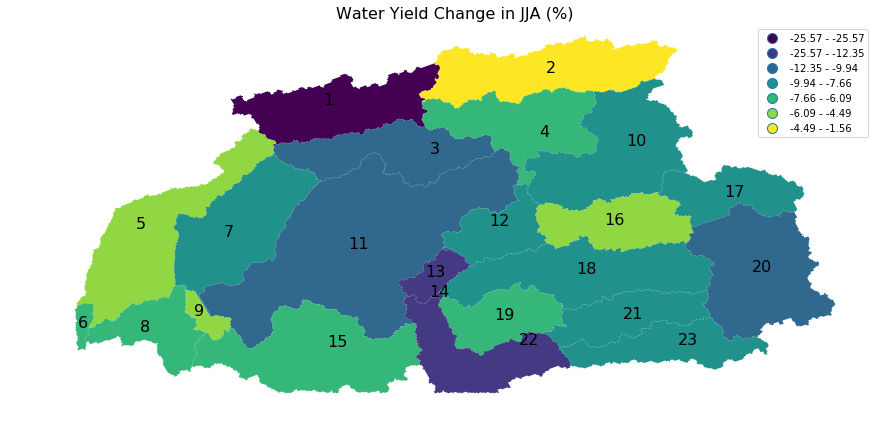

In [11]:
f, ax = plt.subplots(1, figsize = (15, 7))
ax.set_title('Water Yield Change in JJA (%)', fontsize=16)
geo_merge.plot(ax=ax,
               column='JJA', 
               scheme='fisher_jenks', 
               k=7, 
               cmap=plt.cm.viridis, 
               legend=True,
               linewidth = 0.5)

for idx, row in geo_df_ll.iterrows():    
    plt.annotate(s=row['SUB'], xy=row['coords'], fontsize=16, horizontalalignment='center')

ax.set_axis_off()
plt.axis('equal');

## References

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

Rey, Sergio J. (2012) PySAL: A Python Library for Exploratory Spatial Data Analysis and Geocomputation (Movie) SciPy 2012.

Rey, Sergio J. and Luc Anselin. (2010) PySAL: A Python Library of Spatial Analytical Methods. In M. Fischer and A. Getis (eds.) Handbook of Applied Spatial Analysis: Software Tools, Methods and Applications. Springer, Berlin.

Rey, Sergio J. (2009). Show Me the Code: Spatial Analysis and Open Source. Journal of Geographical Systems 11: 191-2007.

http://geopandas.org/


#![img](img\qqq.jpg)